In [1]:
!pip install pandas numpy scikit-learn requests folium

In [13]:
import pandas as pd
import numpy as np
import json
import math
import requests
import time
import re
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
filename = "india_tourism_dataset.json"

with open(filename, "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Extract latitude and longitude from nested coordinates
df['latitude'] = df['coordinates'].apply(lambda x: x.get('latitude') if isinstance(x, dict) else None)
df['longitude'] = df['coordinates'].apply(lambda x: x.get('longitude') if isinstance(x, dict) else None)

# Drop rows missing essential info
df.dropna(subset=['latitude', 'longitude', 'destination_name', 'state'], inplace=True)

# Fill missing popularity_score with median
df['popularity_score'] = df['popularity_score'].fillna(df['popularity_score'].median())

# Add typical_duration if not present (default 2 hours)
if 'typical_duration' not in df.columns:
    df['typical_duration'] = 2
else:
    df['typical_duration'] = df['typical_duration'].fillna(2)

print(f"Loaded {len(df)} places.")
df.head()

Loaded 100 places.


,id,state,district,region,coordinates,altitude_m,popularity_score,accessibility,nearest_airport,nearest_railway_station,...,last_updated,data_sources,user_reviews_summary,recent_developments,sustainability_notes,destination_name,permits_details,latitude,longitude,typical_duration
0,1,Goa,"North Goa, South Goa",West India,"{'latitude': 15.3, 'longitude': 73.8}",50,9,Easy,"{'name': 'Dabolim Airport', 'distance_km': 22}","{'name': 'Margao Railway Station', 'distance_k...",...,2026-01-12,"[web:185, web:186, web:188, web:189, web:192]","Great mix of beaches, nightlife, and heritage;...",Improved coastal safety measures and upgraded ...,Plastic restrictions on several beaches; suppo...,Goa,Not required,15.3000,73.8000,2
1,2,Ladakh,"Leh, Kargil",North India,"{'latitude': 34.16, 'longitude': 77.58}",3505,9,Moderate,{'name': 'Kushok Bakula Rimpochee Airport (Leh...,"{'name': 'Jammu Tawi', 'distance_km': 420}",...,2026-01-12,"[web:181, web:184, web:183]",Spectacular but demanding destination; prepara...,Road and airport upgrades and new homestays ha...,"Water is scarce; avoid plastic, use refillable...",Ladakh (Leh),Inner Line Permits required for areas like Nub...,34.1600,77.5800,2
2,3,Rajasthan,Jaipur,North India,"{'latitude': 26.9124, 'longitude': 75.7873}",431,9,Easy,"{'name': 'Jaipur International Airport', 'dist...","{'name': 'Jaipur Junction', 'distance_km': 3}",...,2026-01-12,"[web:190, web:193, web:183]",Highly recommended for first-time visitors to ...,Tourism infrastructure and palace restoration ...,Support heritage conservation by using authori...,Jaipur,Not required,26.9124,75.7873,2
3,4,Uttar Pradesh,Varanasi,North India,"{'latitude': 25.3176, 'longitude': 82.9739}",81,9,Easy,"{'name': 'Lal Bahadur Shastri Airport', 'dista...","{'name': 'Varanasi Junction / Kashi', 'distanc...",...,2026-01-12,"[web:191, web:194, web:183]",Intense but unforgettable experience; spiritua...,Major riverfront and infrastructure upgrades a...,River-cleaning and ghat conservation underway;...,Varanasi (Kashi),Not required,25.3176,82.9739,2
4,5,Uttar Pradesh,Agra,North India,"{'latitude': 27.1767, 'longitude': 78.0081}",171,10,Easy,{'name': 'Agra Airport (Pandit Deen Dayal Upad...,"{'name': 'Agra Cantt', 'distance_km': 3}",...,2026-01-12,"[web:177, web:183]",Must-see for Taj Mahal; most visitors stay 1–2...,Improved visitor facilities and e-ticketing sy...,Air-quality measures and traffic restrictions ...,Agra,Not required,27.1767,78.0081,2


In [4]:
# Mapping of trip type keywords to green score (0-10, higher = greener)
green_map = {
    'nature': 9,
    'wildlife': 9,
    'trekking': 8,
    'beach': 7,
    'heritage': 5,
    'historical': 5,
    'cultural': 5,
    'adventure': 4,
    'city': 3,
    'shopping': 2
}

def compute_green_score(trip_types):
    if not isinstance(trip_types, list):
        return 5.0  # default
    scores = [green_map.get(t.lower(), 5) for t in trip_types if isinstance(t, str)]
    return np.mean(scores) if scores else 5.0

df['green_score'] = df['trip_types'].apply(compute_green_score)

# Base score (equal weighting for now; preferences will adjust later)
df['base_score'] = 0.7 * df['popularity_score'] + 0.3 * df['green_score']

df[['destination_name', 'popularity_score', 'green_score', 'base_score']].head()

,destination_name,popularity_score,green_score,base_score
0,Goa,9,5.333333,7.90
1,Ladakh (Leh),9,6.000000,8.10
2,Jaipur,9,4.400000,7.62
3,Varanasi (Kashi),9,5.000000,7.80
4,Agra,10,5.000000,8.50


In [5]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def calculate_carbon(dist_km, mode='car'):
    factors = {
        'car': 0.12,
        'bus': 0.08,
        'train': 0.06,
        'flight': 0.25
    }
    return round(dist_km * factors.get(mode, 0.12), 1)

def suggest_transport(dist_km):
    if dist_km < 200:
        mode = 'bus'
        price_estimate = f"₹{int(dist_km * 2)}"
    elif dist_km < 500:
        mode = 'train'
        price_estimate = f"₹{int(dist_km * 1.5)}"
    else:
        mode = 'flight'
        price_estimate = f"₹{int(dist_km * 5)}"
    return mode, price_estimate

In [6]:
# Cache to avoid repeated API calls
_distance_cache = {}

def get_driving_distance(origin_lat, origin_lon, dest_lat, dest_lon, api_key=None):
    key = (origin_lat, origin_lon, dest_lat, dest_lon)
    if key in _distance_cache:
        return _distance_cache[key]

    if api_key:
        url = "https://maps.googleapis.com/maps/api/distancematrix/json"
        params = {
            'origins': f"{origin_lat},{origin_lon}",
            'destinations': f"{dest_lat},{dest_lon}",
            'key': api_key,
            'mode': 'driving'
        }
        try:
            response = requests.get(url, params=params, timeout=5)
            data = response.json()
            if data['status'] == 'OK':
                element = data['rows'][0]['elements'][0]
                if element['status'] == 'OK':
                    dist_m = element['distance']['value']  # meters
                    duration_s = element['duration']['value']  # seconds
                    _distance_cache[key] = (dist_m / 1000, duration_s / 3600)  # km, hours
                    return _distance_cache[key]
        except Exception as e:
            print(f"API error: {e}, falling back to haversine")

    # Fallback to haversine and estimate time at 50 km/h
    dist_km = haversine(origin_lat, origin_lon, dest_lat, dest_lon)
    duration_h = dist_km / 50
    _distance_cache[key] = (dist_km, duration_h)
    return dist_km, duration_h

# Set your API key here (or leave as None)
GOOGLE_API_KEY = None  # Replace with your key if you have one

In [7]:
def adjust_days(num_days, total_places, max_places_per_day, is_india_full=False):
    required = math.ceil(total_places / max_places_per_day)
    if is_india_full and required < 365:
        required = 365
        print("Info: For a complete India tour, days increased to 365.")
    if num_days < required:
        print(f"Info: Extending to {required} days to cover all places.")
        return required
    elif num_days > required:
        print(f"Info: Truncating to {required} days (no extra rest days).")
        return required
    return num_days

In [8]:
def cluster_destinations(coords, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    labels = kmeans.fit_predict(coords)
    if n_clusters > 1:
        sil = silhouette_score(coords, labels)
        print(f"Silhouette score for {n_clusters} clusters: {sil:.3f}")
    return labels, kmeans.cluster_centers_

def reassign_empty_clusters(labels, n_clusters):
    """Ensure each cluster has at least one point."""
    unique, counts = np.unique(labels, return_counts=True)
    cluster_counts = dict(zip(unique, counts))
    empty_clusters = [c for c in range(n_clusters) if c not in cluster_counts]
    if not empty_clusters:
        return labels
    # Find largest cluster
    largest = max(cluster_counts.items(), key=lambda x: x[1])[0]
    # For each empty cluster, move one point from largest
    for empty in empty_clusters:
        idx_to_move = np.where(labels == largest)[0][0]
        labels[idx_to_move] = empty
        # Update counts (not strictly needed further)
    return labels

In [9]:
def nearest_neighbor(dist_matrix, start=0):
    n = len(dist_matrix)
    visited = [False] * n
    path = [start]
    visited[start] = True
    current = start
    for _ in range(n-1):
        next_node = min([(j, dist_matrix[current][j]) for j in range(n) if not visited[j]], key=lambda x: x[1])[0]
        path.append(next_node)
        visited[next_node] = True
        current = next_node
    return path

def calculate_path_distance(path, dist_matrix):
    return sum(dist_matrix[path[i]][path[i+1]] for i in range(len(path)-1))

def two_opt(path, dist_matrix, max_iterations=100):
    best = path[:]
    improved = True
    n = len(path)
    for _ in range(max_iterations):
        improved = False
        for i in range(1, n-2):
            for j in range(i+1, n):
                if j - i == 1:
                    continue
                new_path = best[:i] + best[i:j][::-1] + best[j:]
                if calculate_path_distance(new_path, dist_matrix) < calculate_path_distance(best, dist_matrix):
                    best = new_path
                    improved = True
        if not improved:
            break
    return best

In [10]:
def check_time_feasibility(route_indices, day_coords, visit_durations, max_hours=12, api_key=None):
    """Returns (feasible_bool, total_hours)"""
    total_travel = 0
    total_visit = sum(visit_durations[i] for i in route_indices if i != 0)  # exclude start point
    for k in range(len(route_indices)-1):
        i, j = route_indices[k], route_indices[k+1]
        _, travel_h = get_driving_distance(day_coords[i][0], day_coords[i][1],
                                           day_coords[j][0], day_coords[j][1], api_key)
        total_travel += travel_h
    total = total_travel + total_visit
    return total <= max_hours, round(total, 1)

In [11]:
def generate_itinerary(country="India", num_days=7, max_places_per_day=5,
                       preferences=None, start_location=None, state=None,
                       api_key=None):
    # Copy the global dataframe
    places_df = df.copy()

    # ----- State filter -----
    if state:
        if isinstance(state, str):
            state = [state]
        pattern = '|'.join([re.escape(s.strip()) for s in state])
        mask = places_df['state'].str.contains(pattern, case=False, na=False, regex=True)
        places_df = places_df[mask]
        if places_df.empty:
            return {"error": "No places found in selected state(s)"}
        selected_region = ', '.join(state)
    else:
        selected_region = country

    # ----- Apply preference boosts -----
    places_df['pref_boost'] = 0
    if preferences:
        for cat, weight in preferences.items():
            def boost(row):
                if isinstance(row.get('trip_types'), list):
                    for t in row['trip_types']:
                        if isinstance(t, str) and cat.lower() in t.lower():
                            return weight
                return 0
            places_df['pref_boost'] += places_df.apply(boost, axis=1)
    places_df['final_score'] = places_df['base_score'] + places_df['pref_boost']

    # Sort by final score (but we will keep all places)
    places_df = places_df.sort_values('final_score', ascending=False)

    total_places = len(places_df)
    if total_places == 0:
        return {"error": "No places after filtering"}

    # ----- Adjust number of days -----
    is_india_full = (state is None and country.lower() == "india")
    num_days = adjust_days(num_days, total_places, max_places_per_day, is_india_full)

    # ----- Prepare data -----
    coords = places_df[['latitude', 'longitude']].values
    names = places_df['destination_name'].values
    visit_durations = places_df['typical_duration'].values

    # ----- Starting point -----
    if start_location is None:
        start_lat, start_lon, start_name = 28.6139, 77.2090, "New Delhi (Start)"
    else:
        start_lat = start_location.get('lat', 28.6139)
        start_lon = start_location.get('lon', 77.2090)
        start_name = start_location.get('name', "Custom Start")
        # Try to match to a known place
        for i, name in enumerate(names):
            if start_name.lower() in name.lower() or name.lower() in start_name.lower():
                start_name = name
                start_lat, start_lon = coords[i]
                break

    # ----- Clustering -----
    n_clusters = min(num_days, total_places)
    labels, centers = cluster_destinations(coords, n_clusters)
    labels = reassign_empty_clusters(labels, n_clusters)

    # Build day -> indices mapping
    day_to_indices = {i: [] for i in range(n_clusters)}
    for idx, lab in enumerate(labels):
        day_to_indices[lab].append(idx)

    # ----- Build itinerary day by day -----
    itinerary = []
    total_carbon = 0.0
    total_distance = 0.0

    prev_lat, prev_lon = start_lat, start_lon
    prev_name = start_name

    for day in range(num_days):
        day_indices = day_to_indices.get(day, [])
        if not day_indices:
            # This shouldn't happen after reassign, but just in case
            for other in day_to_indices:
                if day_to_indices[other]:
                    moved = day_to_indices[other].pop()
                    day_indices = [moved]
                    break

        # Get data for this day
        day_places_df = places_df.iloc[day_indices].sort_values('final_score', ascending=False)
        day_places = day_places_df['destination_name'].values
        day_coords = day_places_df[['latitude', 'longitude']].values
        day_durations = day_places_df['typical_duration'].values

        # Prepend previous day's end
        all_coords = np.vstack([(prev_lat, prev_lon), day_coords])
        all_names = np.insert(day_places, 0, prev_name)
        all_durations = np.insert(day_durations, 0, 0)  # start point has 0 visit time

        n = len(all_coords)
        if n < 2:
            itinerary.append({
                "day": day+1,
                "route": all_names[0],
                "distance": 0,
                "carbon": 0,
                "mode": "local",
                "price_estimate": "₹0",
                "warning": "Only one place"
            })
            prev_lat, prev_lon = all_coords[0]
            prev_name = all_names[0]
            continue

        # Build distance and time matrices (using real distances if API key provided)
        dist_matrix = np.zeros((n, n))
        time_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                d_km, t_h = get_driving_distance(all_coords[i][0], all_coords[i][1],
                                                  all_coords[j][0], all_coords[j][1], api_key)
                dist_matrix[i][j] = dist_matrix[j][i] = d_km
                time_matrix[i][j] = time_matrix[j][i] = t_h

        # Solve TSP (nearest neighbor + 2-opt)
        path = nearest_neighbor(dist_matrix, start=0)
        path = two_opt(path, dist_matrix)

        # Compute total distance and travel time
        day_dist = sum(dist_matrix[path[k]][path[k+1]] for k in range(len(path)-1))
        day_travel_time = sum(time_matrix[path[k]][path[k+1]] for k in range(len(path)-1))
        day_visit_time = sum(all_durations[i] for i in path if i != 0)
        day_total_time = day_travel_time + day_visit_time

        # Check feasibility (12‑hour day)
        feasible = day_total_time <= 12

        # Suggest transport based on longest leg
        max_leg = max([dist_matrix[path[k]][path[k+1]] for k in range(len(path)-1)], default=0)
        mode, price = suggest_transport(max_leg)

        # Carbon footprint
        carbon = sum(calculate_carbon(dist_matrix[path[k]][path[k+1]], mode) for k in range(len(path)-1))

        total_carbon += carbon
        total_distance += day_dist

        # Build route string
        route_names = [all_names[i] for i in path]
        route = " → ".join(route_names)

        # Update end point for next day
        prev_name = route_names[-1]
        prev_lat, prev_lon = all_coords[path[-1]]

        # Warnings
        warnings = []
        if not feasible:
            warnings.append(f"Day too long ({day_total_time:.1f}h > 12h)")
        if day_dist > 500:
            warnings.append("Long travel distance")
        if len(day_indices) > max_places_per_day:
            warnings.append(f"More than {max_places_per_day} places")

        itinerary.append({
            "day": day+1,
            "route": route,
            "distance": round(day_dist, 1),
            "carbon": round(carbon, 1),
            "mode": mode,
            "price_estimate": price,
            "total_time_h": round(day_total_time, 1),
            "warning": "; ".join(warnings) if warnings else "OK"
        })

    return {
        "summary_title": f"Your {num_days}-Day Eco-Trip in {selected_region}",
        "total_carbon": round(total_carbon, 1),
        "total_distance": round(total_distance, 1),
        "days": itinerary
    }

In [12]:
# Example: 5-day trip in Rajasthan starting from Delhi, with heritage preference
test_result = generate_itinerary(
    num_days=5,
    state="Rajasthan",
    start_location={"lat": 28.6139, "lon": 77.2090, "name": "Delhi"},
    preferences={"heritage": 2.0},
    api_key=GOOGLE_API_KEY
)

# Print the result nicely
print(json.dumps(test_result, indent=2, ensure_ascii=False))

Info: Truncating to 2 days (no extra rest days).
Silhouette score for 2 clusters: 0.577
{
  "summary_title": "Your 2-Day Eco-Trip in Rajasthan",
  "total_carbon": 283.3,
  "total_distance": 1717.2,
  "days": [
    {
      "day": 1,
      "route": "Delhi → Udaipur → Jaisalmer & Thar Desert Dunes → Jaisalmer (Thar Desert & Fort Town)",
      "distance": 949.1,
      "carbon": 237.3,
      "mode": "flight",
      "price_estimate": "₹2834",
      "total_time_h": 25.0,
      "warning": "Day too long (25.0h > 12h); Long travel distance"
    },
    {
      "day": 2,
      "route": "Jaisalmer (Thar Desert & Fort Town) → Jaipur → Ranthambore National Park → Keoladeo National Park (Bharatpur Bird Sanctuary)",
      "distance": 768.1,
      "carbon": 46.0,
      "mode": "train",
      "price_estimate": "₹725",
      "total_time_h": 21.4,
      "warning": "Day too long (21.4h > 12h); Long travel distance"
    }
  ]
}


In [1]:
import json
from backend import generate_itinerary, df

# -------------------------------
# Test cases
# -------------------------------
test_cases = [
    {
        "name": "Rajasthan (5 days, 3/day, from Delhi)",
        "state": "Rajasthan",
        "num_days": 5,
        "max_places_per_day": 3,
        "start": {"lat": 28.6139, "lon": 77.2090, "name": "Delhi"},
        "travel_day": False
    },
    {
        "name": "Goa (3 days, 4/day, from Mumbai, travel day)",
        "state": "Goa",
        "num_days": 3,
        "max_places_per_day": 4,
        "start": {"lat": 19.0760, "lon": 72.8777, "name": "Mumbai"},
        "travel_day": True
    },
    {
        "name": "Kerala (7 days, 2/day, from Kochi)",
        "state": "Kerala",
        "num_days": 7,
        "max_places_per_day": 2,
        "start": {"lat": 9.9312, "lon": 76.2673, "name": "Kochi"},
        "travel_day": False
    },
    {
        "name": "Uttar Pradesh (4 days, 3/day, from Varanasi)",
        "state": "Uttar Pradesh",
        "num_days": 4,
        "max_places_per_day": 3,
        "start": {"lat": 25.3176, "lon": 82.9739, "name": "Varanasi"},
        "travel_day": False
    },
    {
        "name": "All India (30 days, 3/day, from Delhi)",
        "state": None,  # All India
        "num_days": 30,
        "max_places_per_day": 3,
        "start": {"lat": 28.6139, "lon": 77.2090, "name": "Delhi"},
        "travel_day": False
    }
]

# -------------------------------
# Metrics collection
# -------------------------------
results = []

for case in test_cases:
    print(f"\n=== Testing: {case['name']} ===")
    try:
        result = generate_itinerary(
            num_days=case["num_days"],
            max_places_per_day=case["max_places_per_day"],
            start_location=case["start"],
            state=case["state"],
            travel_day_only=case["travel_day"]
        )
    except Exception as e:
        print(f"ERROR: {e}")
        continue

    if "error" in result:
        print(f"Error from generator: {result['error']}")
        continue

    days = result["days"]
    total_days = len(days)
    feasible_days = sum(1 for d in days if d["total_time_h"] <= 12)
    feasibility = feasible_days / total_days if total_days > 0 else 0

    # Average distance per day
    avg_distance = sum(d["distance"] for d in days) / total_days if total_days > 0 else 0
    # Average carbon per day
    avg_carbon = sum(d["carbon"] for d in days) / total_days if total_days > 0 else 0
    # Average places per day (excluding travel days)
    sightseeing_days = [d for d in days if d.get("type") != "travel"]
    avg_places = sum(len(d["route"].split(" → ")) - 1 for d in sightseeing_days) / len(sightseeing_days) if sightseeing_days else 0

    # Coverage: all destinations in the selected state(s) appear?
    # For state=None (All India), we skip coverage check because it's huge.
    if case["state"] is not None:
        # Get all places in that state from the original dataframe
        state_places = set(df[df["state"].str.contains(case["state"], case=False, na=False)]["destination_name"])
        # Places in itinerary
        itinerary_places = set()
        for d in days:
            for p in d["route"].split(" → "):
                # Remove "(Start)" suffix if present
                if p.endswith(" (Start)"):
                    p = p[:-7]
                itinerary_places.add(p)
        missing = state_places - itinerary_places
        coverage = (len(state_places) - len(missing)) / len(state_places) * 100
    else:
        coverage = "N/A"

    # Budget
    budget = result["budget"]

    # Store metrics
    metrics = {
        "test_name": case["name"],
        "requested_days": case["num_days"],
        "actual_days": total_days,
        "feasibility_%": feasibility * 100,
        "avg_distance_km": round(avg_distance, 1),
        "avg_carbon_kg": round(avg_carbon, 1),
        "avg_places_per_day": round(avg_places, 1),
        "coverage_%": round(coverage, 1) if coverage != "N/A" else "N/A",
        "total_transport_cost": budget["transport"],
        "total_budget": budget["total"],
    }

    results.append(metrics)

    # Print summary for this case
    print(f"  Requested days: {case['num_days']}, Actual days: {total_days}")
    print(f"  Feasibility: {feasibility*100:.1f}% ({feasible_days}/{total_days} days ≤12h)")
    print(f"  Avg distance/day: {avg_distance:.1f} km")
    print(f"  Avg carbon/day: {avg_carbon:.1f} kg")
    print(f"  Avg places/day (sightseeing): {avg_places:.1f}")
    if coverage != "N/A":
        print(f"  Coverage: {coverage:.1f}% of state places included")
    print(f"  Total transport cost: ₹{budget['transport']}")
    print(f"  Total budget (incl. accommodation): ₹{budget['total']}")

# -------------------------------
# Overall summary table
# -------------------------------
print("\n\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
for m in results:
    print(f"{m['test_name']}:")
    print(f"  Days: {m['requested_days']} req → {m['actual_days']} act | Feasibility: {m['feasibility_%']:.1f}%")
    print(f"  Avg dist: {m['avg_distance_km']} km | Avg carbon: {m['avg_carbon_kg']} kg | Places/day: {m['avg_places_per_day']}")
    if m['coverage_%'] != "N/A":
        print(f"  Coverage: {m['coverage_%']}%")
    print(f"  Transport: ₹{m['total_transport_cost']} | Total: ₹{m['total_budget']}")
    print("-"*40)

# Optionally save to JSON
with open("evaluation_results.json", "w") as f:
    json.dump(results, f, indent=2)
print("\nResults saved to evaluation_results.json")

After deduplication: 93 unique places
Hub info built for 93 destinations.
Destinations with hub data: 93

=== Testing: Rajasthan (5 days, 3/day, from Delhi) ===
Silhouette score for 2 clusters: 0.577
  Splitting day 1 (internal est. 382.2 km > 300 km)
  Splitting day 0 (actual 448.9 km > 300 km)
  Splitting day 2 (actual 382.2 km > 300 km)
  Requested days: 5, Actual days: 5
  Feasibility: 100.0% (5/5 days ≤12h)
  Avg distance/day: 232.6 km
  Avg carbon/day: 15.8 kg
  Avg places/day (sightseeing): 1.2
  Coverage: 100.0% of state places included
  Total transport cost: ₹1723
  Total budget (incl. accommodation): ₹11723

=== Testing: Goa (3 days, 4/day, from Mumbai, travel day) ===
  Splitting day 0 (actual 471.1 km > 300 km)
  Requested days: 3, Actual days: 2
  Feasibility: 100.0% (2/2 days ≤12h)
  Avg distance/day: 235.6 km
  Avg carbon/day: 14.5 kg
  Avg places/day (sightseeing): 1.0
  Coverage: 100.0% of state places included
  Total transport cost: ₹725
  Total budget (incl. accomm

Total destinations: 93
Clustering with k=2...
Clustering with k=3...
Clustering with k=4...
Clustering with k=5...
Clustering with k=6...
Clustering with k=7...
Clustering with k=8...
Clustering with k=9...
Clustering with k=10...
Clustering with k=11...
Clustering with k=12...
Clustering with k=13...
Clustering with k=14...
Clustering with k=15...
Clustering with k=16...
Clustering with k=17...
Clustering with k=18...
Clustering with k=19...
Clustering with k=20...
Clustering with k=21...
Clustering with k=22...
Clustering with k=23...
Clustering with k=24...
Clustering with k=25...
Clustering with k=26...
Clustering with k=27...
Clustering with k=28...
Clustering with k=29...
Clustering with k=30...


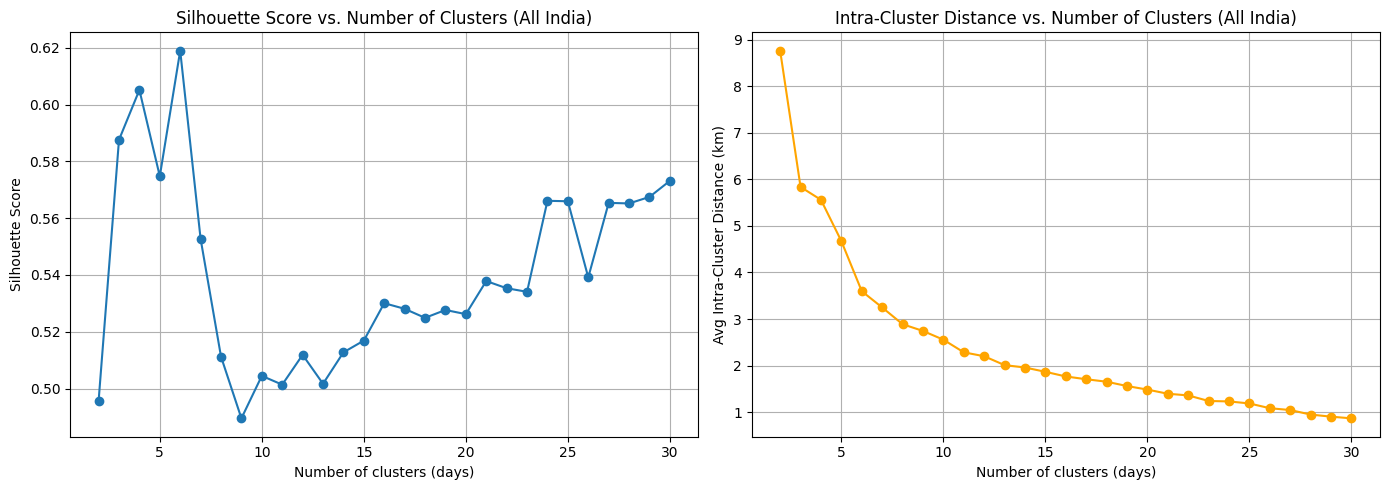

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.cluster import KMeans
import numpy as np
from backend import df  # uses your global dataframe

# Use the full dataset
coords = df[['latitude', 'longitude']].values
n_samples = len(coords)
print(f"Total destinations: {n_samples}")

# We'll test from 2 to min(30, n_samples-1) for readability
max_k = min(30, n_samples - 1)
k_values = range(2, max_k + 1)
sil_scores = []
intra_distances = []

for k in k_values:
    print(f"Clustering with k={k}...")
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(coords)
    
    # Silhouette score
    sil = silhouette_score(coords, labels)
    sil_scores.append(sil)
    
    # Intra-cluster distance (mean pairwise distance within clusters)
    intra = 0
    count = 0
    for c in range(k):
        mask = labels == c
        cluster_pts = coords[mask]
        if len(cluster_pts) > 1:
            dists = pairwise_distances(cluster_pts)
            # sum of upper triangle (excluding diagonal)
            total = np.sum(dists[np.triu_indices_from(dists, k=1)])
            pairs = len(cluster_pts) * (len(cluster_pts) - 1) / 2
            intra += total
            count += pairs
    avg_intra = intra / count if count > 0 else 0
    intra_distances.append(avg_intra)

# Plot silhouette scores
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, sil_scores, marker='o', linestyle='-')
plt.xlabel('Number of clusters (days)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters (All India)')
plt.grid(True)

# Plot intra-cluster distance
plt.subplot(1, 2, 2)
plt.plot(k_values, intra_distances, marker='o', linestyle='-', color='orange')
plt.xlabel('Number of clusters (days)')
plt.ylabel('Avg Intra‑Cluster Distance (km)')
plt.title('Intra‑Cluster Distance vs. Number of Clusters (All India)')
plt.grid(True)

plt.tight_layout()
plt.show()